In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
import torch
from transformers import  AutoTokenizer
from transformers import AutoModelForCausalLM, AutoConfig

device = 'cuda'

model_name = "microsoft/phi-2"
phi2_model_pretrained = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype = torch.float16
)

phi2_model_pretrained.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.bos_token = tokenizer.eos_token

In [ ]:
phi2_model_pretrained

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2560,),

### Create dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import json
import os
import h5py

In [ ]:
def get_image_name(image_id_from_caption, list_image_info):
    for img in list_image_info:
        if img['id'] == image_id_from_caption:
            img_name = img['file_name'].split('.')[0]
            return img['file_name'].split('.')[0]
    return 'NoImgNameFound'

In [ ]:
# file_path_captions_coco = '/media/App/amaranth/lavanya/Capstone_data/annotations_trainval2017/annotations/captions_train2017.json'

# with open(file_path_captions_coco) as f:
#    data = json.load(f)

# captions_info = []
# for a in data['annotations']:
#     captions_info.append([a['image_id'], a['caption'], a['id']])

# captions_info_df = pd.DataFrame(data=captions_info, columns=['image_id', 'caption', 'caption_id'])
# captions_info_df['image_name'] = captions_info_df['image_id'].apply(lambda x: get_image_name(x, data['images']))
# captions_info_df['image_name'] = captions_info_df['image_name'].apply(lambda x: '0'*(12-len(str(x))) + str(x))
# captions_info_df.to_csv('captions_images_map_COCO_train2017.csv', index = False)

In [ ]:
captions_info_df = pd.read_csv('captions_images_map_COCO_train2017.csv')

/tmp/ipykernel_2293959/1237926302.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  captions_info_df = pd.read_csv('captions_images_map_COCO_train2017.csv')


In [ ]:
captions_info_df

,image_id,caption,caption_id,image_name
0,203564,A bicycle replica with a clock as the front wh...,37,203564
1,322141,A room with blue walls and a white sink and door.,49,322141
2,16977,A car that seems to be parked illegally behind...,89,16977
3,106140,A large passenger airplane flying through the ...,98,106140
4,106140,There is a GOL plane taking off in a partly cl...,101,106140
...,...,...,...,...
591748,133071,a slice of bread is covered with a sour cream ...,829655,133071
591749,410182,A long plate hold some fries with some sliders...,829658,410182
591750,180285,Two women sit and pose with stuffed animals.,829665,180285
591751,133071,White Plate with a lot of guacamole and an ext...,829693,133071


In [ ]:
captions_info_df['token_size'] = captions_info_df['caption'].apply(lambda x: tokenizer(x, return_tensors="pt",
                                               return_attention_mask=False).input_ids.shape[1])

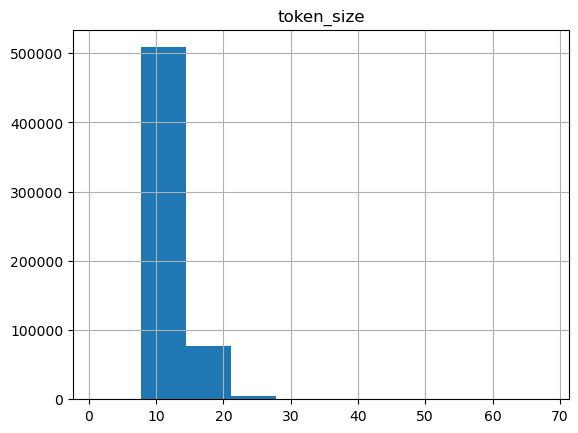

In [ ]:
hist = captions_info_df.hist(['token_size'])

In [ ]:
import h5py
import numpy as np

In [ ]:
class COCO_CLIP_Dataset(Dataset):

    def __init__(
        self, caption_file, embedding_path, tokenizer, max_token_len_data):

        self.embedding_path = embedding_path
        self.caption_file = caption_file
        self.tokenizer = tokenizer
        self.max_token_len_data = max_token_len_data

    def __len__(self):
        return len(self.caption_file)

    def __getitem__(self, index):

        row = self.caption_file.iloc[[index]]

        df_img = row['image_id'].values[0]
        img_base_name = '0'*(12-len(str(df_img))) + str(df_img)
        img_base_name = img_base_name.replace(' ', '0')
        img_clip_embedding_path = os.path.join(self.embedding_path, f'{img_base_name}.h5')

        np_array_embed_img = h5py.File(img_clip_embedding_path,'r+')['image_features'][()]

        img_caption = row['caption'].values[0] ## Tokenize this
        img_caption_tokenized = self.tokenizer(img_caption, return_tensors="pt",
                                               return_attention_mask=False).input_ids

        ## put bos, eos, and padding for batch
        # input_bos = torch.cat((torch.tensor(self.tokenizer.bos_token_id).view((1,1)),
        #                                                img_caption_tokenized), dim=1)

        input_bos = img_caption_tokenized

        input_eos = torch.cat((input_bos,
                               torch.tensor(self.tokenizer.eos_token_id).view((1,1))), dim=1)

        if (self.max_token_len_data - input_eos.shape[1]) > 0:
            input_final =  torch.cat((input_eos,torch.tensor([self.tokenizer.pad_token_id]*(self.max_token_len_data - input_eos.shape[1])).unsqueeze(0)), dim=1)
        else:
            input_final = input_eos

        return torch.tensor(np_array_embed_img).squeeze(0), input_final.squeeze(0)

In [ ]:
def file_exists(image_id, fpath = '/media/App/amaranth/lavanya/Capstone_data/clip_features_base_patch32/'):

    n = '0'*(12-len(str(image_id))) + str(image_id) + '.h5'
    fp = os.path.join(fpath, n)

    if os.path.exists(fp):
        return True
    else:
        return False

In [ ]:
### captions_info_df contains for 1 image multiple entries, lets reduce keeping one image, one entry.
captions_info_df_subset = captions_info_df.drop_duplicates(subset='image_id', keep='first')
captions_info_df_subset = captions_info_df_subset[captions_info_df_subset['token_size'] <=30]

In [ ]:
max_token_len_data = 75
dataset = COCO_CLIP_Dataset(captions_info_df_subset,
                            '/media/App/amaranth/lavanya/Capstone_data/clip_features_base_patch32/',
                            tokenizer, max_token_len_data)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResBlock(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.pre_norm = nn.LayerNorm(input_size)
        self.proj = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.GELU(),
            nn.Linear(input_size, input_size)
        )
    def forward(self, x):
        x = self.pre_norm(x)
        return x + self.proj(x)

class Phi2wrapper(nn.Module):

    #This defines the structure of the NN.
    def __init__(self, input_dim_CLIP=768, input_dim_phi2=2560,
                 phi2_model=phi2_model_pretrained,
                 max_token_len_data=max_token_len_data, tokenizer=tokenizer, teacher_forcing = 3, device=device):

        super(Phi2wrapper, self).__init__()

        self.input_dim_CLIP = input_dim_CLIP
        self.input_dim_phi2 = input_dim_phi2
        self.projection_img = nn.Linear(self.input_dim_CLIP, self.input_dim_phi2,
                                        bias=False)

        self.resblock = SimpleResBlock(self.input_dim_phi2)
        self.phi2_model = phi2_model
        self.max_token_len_data = max_token_len_data
        self.tokenizer = tokenizer

        self.device = device
        self.teacher_forcing = teacher_forcing

        bos = self.tokenizer("Image: ", return_tensors="pt", return_attention_mask=False)
        eoi = self.tokenizer(" Caption: ", return_tensors="pt", return_attention_mask=False)

        self.bos_embedding = self.phi2_model.get_input_embeddings()(bos.input_ids.to(self.device)).squeeze(0)
        self.eoi_embedding = self.phi2_model.get_input_embeddings()(eoi.input_ids.to(self.device)).squeeze(0)
        self.eos_embedding = self.phi2_model.get_input_embeddings()(torch.tensor(self.tokenizer.eos_token_id).to(self.device)).unsqueeze(0)

    def forward(self, x, input_caption):

        x = self.projection_img(x)
        x = self.resblock(x)

        batch_size = x.shape[0]

        x = torch.cat((self.bos_embedding.repeat(batch_size,1,1), x,
                    self.eoi_embedding.repeat(batch_size,1,1)), dim=1)

        loss = 0
        word_output_pred_tokens = None

        for idx in range(input_caption.shape[1]):

            out_phi = self.phi2_model.model.layers[0](x.to(torch.float16))

            for layer_idx in range(1, 32):
                out_phi = self.phi2_model.model.layers[layer_idx](out_phi[0])

            out_phi = self.phi2_model.model.final_layernorm(out_phi[0])
            out_phi = self.phi2_model.lm_head(zzout_phi) ## torch.Size([batch, 55, 50297])

            next_word = torch.argmax(out_phi[:, -1, :], dim=-1) ## [batch]

            caption_word_token = input_caption[:,idx]

#             print("Decode:", self.tokenizer.decode(next_word))
#             print("Decode gt:", self.tokenizer.decode(caption_word_token))

            no_of_pad_tokens = sum(torch.eq(torch.tensor([self.tokenizer.pad_token_id]*batch_size).to(self.device), caption_word_token))

            if no_of_pad_tokens == torch.tensor(batch_size):
                break

            if idx>=self.teacher_forcing:
#                 print(idx, " next word model", self.tokenizer.decode(next_word))
                caption_word_embedding = self.phi2_model.get_input_embeddings()(next_word).unsqueeze(1)
            else:
#                 print(idx, " next word ground truth", self.tokenizer.decode(caption_word_token))
                caption_word_embedding = self.phi2_model.get_input_embeddings()(caption_word_token).unsqueeze(1)

            ## instead of append like instruct image output words.. instruct image w1 out, instruct image w2 output ..
            x = torch.cat((x, caption_word_embedding), dim=1)

            loss_val = F.cross_entropy(out_phi[:, -1, :], caption_word_token,
                        ignore_index=self.tokenizer.pad_token_id)

            loss += loss_val

            if word_output_pred_tokens is None:
                word_output_pred_tokens = next_word.unsqueeze(1)
            else:

                word_output_pred_tokens = torch.cat((word_output_pred_tokens, next_word.unsqueeze(1)), dim=1)

        return loss/idx, word_output_pred_tokens


torch.set_grad_enabled(True)
phi2_projection_model = Phi2wrapper().to(device=device)

## Freezing phi-2 for projection layer training
for name, param in phi2_projection_model.named_parameters():
    if "phi2_model" in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class SimpleResBlock(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.pre_norm = nn.LayerNorm(input_size)
#         self.proj = nn.Sequential(
#             nn.Linear(input_size, input_size),
#             nn.GELU(),
#             nn.Linear(input_size, input_size)
#         )
#     def forward(self, x):
#         x = self.pre_norm(x)
#         return x + self.proj(x)

# class Phi2wrapper(nn.Module):

#     #This defines the structure of the NN.
#     def __init__(self, input_dim_CLIP=768, input_dim_phi2=2560,
#                  phi2_model=phi2_model_pretrained,
#                  max_token_len_data=max_token_len_data, tokenizer=tokenizer, device=device):

#         super(Phi2wrapper, self).__init__()

#         self.input_dim_CLIP = input_dim_CLIP
#         self.input_dim_phi2 = input_dim_phi2
#         self.projection_img = nn.Linear(self.input_dim_CLIP, self.input_dim_phi2,
#                                         bias=False)

# #         1, 49, 2560
# #         1, 75, 2560 <-- embedding of Image (training) x the model predict (CLIP)

# #         caption_tkens = tokenizer(caption, return_tensors="pt", return_attention_mask=False)
# #         caption_gt_embediing = phi2_model.get_input_embeddings()(torch.tensor(caption_tokens).to(self
# #         1, 75, 2560 <-- output y

#         self.resblock = SimpleResBlock(self.input_dim_phi2)
#         self.phi2_model = phi2_model
#         self.max_token_len_data = max_token_len_data
#         self.tokenizer = tokenizer

#         self.device = device

#         bos = self.tokenizer("Image: ", return_tensors="pt", return_attention_mask=False)
#         eoi = self.tokenizer(" Caption: ", return_tensors="pt", return_attention_mask=False)

#         self.bos_embedding = self.phi2_model.get_input_embeddings()(bos.input_ids.to(self.device)).squeeze(0)
#         self.eoi_embedding = self.phi2_model.get_input_embeddings()(eoi.input_ids.to(self.device)).squeeze(0)
#         self.eos_embedding = self.phi2_model.get_input_embeddings()(torch.tensor(self.tokenizer.eos_token_id).to(self.device)).unsqueeze(0)

#     def forward(self, x, input_caption):

#         x = self.projection_img(x)
#         x = self.resblock(x)

#         batch_size = x.shape[0]

# #         imgae_prompt_embed = x.clone()
#         x = torch.cat((self.bos_embedding.repeat(batch_size,1,1), x,
#                     self.eoi_embedding.repeat(batch_size,1,1)), dim=1)

#         loss = 0
#         word_output_pred_tokens = None

#         for idx in range(input_caption.shape[1]):

# #             next_word = self.phi2_model.forward(inputs_embeds=x.to(torch.float16))["logits"][:, -1, :]

#             next_word = self.phi2_model.generate(inputs_embeds=x.to(torch.float16), max_new_tokens = 1,
#                                             output_scores=True, return_dict_in_generate = True,
#                                             pad_token_id=self.tokenizer.pad_token_id,
#                                             bos_token_id=self.tokenizer.bos_token_id,
#                                             eos_token_id=self.tokenizer.eos_token_id) ## this gives first word

#             caption_word_token = input_caption[:,idx]

#             no_of_pad_tokens = sum(torch.eq(torch.tensor([self.tokenizer.pad_token_id]*batch_size).to(self.device), caption_word_token))
#             if no_of_pad_tokens == torch.tensor(batch_size):
#                 break

#             caption_word_embedding = self.phi2_model.get_input_embeddings()(caption_word_token).unsqueeze(1)

#             ## instead of append like instruct image output words.. instruct image w1 out, instruct image w2 output ..
#             x = torch.cat((x, caption_word_embedding), dim=1)

# #             caption_word_token_new = input_caption[:, :idx+1]
# #             caption_word_embedding_new = self.phi2_model.get_input_embeddings()(caption_word_token_new)
# #             x = torch.cat((self.bos_embedding.repeat(batch_size,1,1), imgae_prompt_embed, caption_word_embedding_new,
# #                     self.eoi_embedding.repeat(batch_size,1,1)), dim=1)

# #             loss_val = F.cross_entropy(F.softmax(next_word, dim=-1), caption_word_token,
# #                         ignore_index=self.tokenizer.pad_token_id, label_smoothing=0.1)

#             loss_val = F.cross_entropy(next_word.scores[0], caption_word_token,
#                         ignore_index=self.tokenizer.pad_token_id, label_smoothing=0.1)

#             loss += loss_val

# #             if word_output_pred_tokens is None:
# #                 word_output_pred_tokens = torch.argmax(next_word,dim=-1).unsqueeze(1)
# #             else:

# #                 word_output_pred_tokens = torch.cat((word_output_pred_tokens, torch.argmax(next_word,dim=-1).unsqueeze(1)), dim=1)

#             if word_output_pred_tokens is None:
#                 word_output_pred_tokens = next_word.sequences[:, 1].unsqueeze(1)
#             else:
#                 word_output_pred_tokens = torch.cat((word_output_pred_tokens, next_word.sequences[:, 1].unsqueeze(1)), dim=1)

#         loss_tosend = loss/idx

#         return loss_tosend, word_output_pred_tokens

#         ### Without feature forcing
#         # x = self.phi2_model.generate(inputs_embeds=x,
#         #                              max_new_tokens=self.max_token_len_data,
#         #                              output_scores=True, return_dict_in_generate = True,
#         #                              pad_token_id=self.tokenizer.eos_token_id,
#         #                              bos_token_id=self.tokenizer.bos_token_id,
#         #                              eos_token_id=self.tokenizer.eos_token_id)

#         # return x

# torch.set_grad_enabled(True)
# phi2_projection_model = Phi2wrapper().to(device=device)

# ## Freezing phi-2 for projection layer training
# for name, param in phi2_projection_model.named_parameters():
#     if "phi2_model" in name:
#         param.requires_grad = False
#     else:
#         param.requires_grad = True

In [ ]:
batch_size_train = 2
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True, num_workers=8)

num_batches_train_on = 30000
num_batches_train_on, len(train_dataloader)

(30000, 59088)

In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,
                                    phi2_projection_model.parameters()),
                            lr=1e-5, eps=1e-9)

In [ ]:
num_epochs = 3
vocab_size = len(tokenizer)

phi2_projection_model.train()
N_batches = len(train_dataloader)

In [ ]:
epoch

1

In [ ]:
for epoch in range(epoch, num_epochs):

    print(f"Working on epoch {epoch}")

    for iteration, batch in enumerate(train_dataloader):

#         if iteration == num_batches_train_on:
#             break

        optimizer.zero_grad()

        input_ = batch[0]
        gt = batch[1]

        loss, output_pred_tokens = phi2_projection_model(input_.to(device), gt.to(device))

#         loss.requires_grad = True ## use with geenrate
        loss.backward(retain_graph=True)

        optimizer.step()

        if (iteration % 100) == 0:
            print("Loss:", loss)
            print("Iteration:", iteration)
            print("Predictions:", tokenizer.batch_decode(output_pred_tokens)[0].rstrip())
            print("Gt:", tokenizer.batch_decode(gt)[0].split('<|endoftext|>')[0])

    print("")
    print(f"Epoch {epoch} finished")
    print("")

Working on epoch 1
Loss: tensor(1.8721, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 0
Predictions: A cat up of a cat sitting a a a sink
Gt: a close up of a cat on a bath room sink 
Loss: tensor(4.2773, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 100
Predictions: A man riding on a horse a carriage carriage a...........
Gt: A man sits on a horse drawn carriage in front of a building with people sitting at tables outside. 
Loss: tensor(2.9297, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 200
Predictions: A woman riding a horse riding a a a....
Gt: A man with a bucket hat riding a hose on a beach.
Loss: tensor(2.6543, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 300
Predictions: A man in a tennis ball a a a....
Gt: A man holding a racquet on top of a tennis court.
Loss: tensor(2.6152, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 400
Predictions: A ba

Loss: tensor(4.9648, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 3900
Predictions: A large bench with a a a a.......
Gt: A park bench with two stones piled on top of each other
Loss: tensor(3.8516, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4000
Predictions: A are a table of boxes of food.....
Gt: People surrounding a few boxes of donuts on a table.
Loss: tensor(6.7500, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4100
Predictions: A bunch and a a a a a a a....................
Gt: A women on a bed looking at a kitten.
Loss: tensor(3.3047, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4200
Predictions: Three people are sitting on a a a a a
Gt: the people are sitting on the couch together
Loss: tensor(4.3984, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4300
Predictions: A empty and bed with a a a a..
Gt: An orange plastic chair is next to the larg

Loss: tensor(5.8555, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 7900
Predictions: A plate with food with a with and vegetables...
Gt: A plate of different types of healthy foods.
Loss: tensor(4.2656, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8000
Predictions: A are standing in a a a a....
Gt: People are standing around a carousel waiting for their luggage.
Loss: tensor(4.6523, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8100
Predictions: A man couple of a a a a.......
Gt: A smiling couple with their arms around each other at a party
Loss: tensor(3.7480, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8200
Predictions: A people standing a standing a a a.....
Gt: Two people, formally dressed, are smiling for the camera. 
Loss: tensor(3.2246, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8300
Predictions: A cows are in the a a a..
Gt: Many cows layi

Loss: tensor(3.8809, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 11900
Predictions: A large truck with a a a a a a
Gt: a red truck a yellow crane some water boats and trees
Loss: tensor(3.1152, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12000
Predictions: A man walking walking down a street a a a.....
Gt: A man is walking down the street next to a pole with a clock.
Loss: tensor(3.1309, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12100
Predictions: A train train blue train sitting a a tracks a
Gt: a white and blue bullet train on its track
Loss: tensor(4.1172, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12200
Predictions: A woman pushing a baby in a a a....
Gt: A woman and baby smile at the camera.
Loss: tensor(3.1680, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12300
Predictions: A man holding a a of a a........
Gt: A man eating a donut in f

Loss: tensor(3.9141, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 15900
Predictions: A man man wearing a a tie tie a tie.
Gt: a bald man wearing a tux outdoors 
Loss: tensor(3.9121, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16000
Predictions: A street are the street are the the of...
Gt: The people on the street are shopping for fruit.
Loss: tensor(4.7148, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16100
Predictions: A woman reality woman sitting on a laptop a a a a a a
Gt: a virtual blonde girl is on the floor
Loss: tensor(3.6191, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16200
Predictions: A people standing by a of of of a......
Gt: Two men surrounded by several large piles of bananas.
Loss: tensor(2.4023, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16300
Predictions: A herd of cows grazing in a field field....
Gt: A group of cows are gr

Loss: tensor(3.3164, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 19900
Predictions: A holding pizza sitting on a a a a.
Gt: Hand tossed pizza on a rack with others.
Loss: tensor(2.7324, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20000
Predictions: A potaming pot of vegetables vegetables and vegetables...
Gt: a steaming pot cooking many types of vegetables.
Loss: tensor(3.5020, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20100
Predictions: A banana sitting on a a a a a a....
Gt: A banana rests on a container of blackberries.
Loss: tensor(3.1699, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20200
Predictions: Aier is the snow slope snow snow slope..
Gt: Skier in open area of deep snow near trees.
Loss: tensor(4.1211, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20300
Predictions: A man is is holding a a a a....
Gt: A man that is staring at his re

Loss: tensor(2.7578, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 23900
Predictions: A group number with boats boats in the water..
Gt: A large harbor filled with lots of boats on water.
Loss: tensor(4.3047, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 24000
Predictions: A riding riding on an elephant elephant elephant..........
Gt: People are riding an elephant and an umbrella.
Loss: tensor(3.1641, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 24100
Predictions: A don glazed donnut on a a a.
Gt: A heavily glazed donut sitting on the counter
Loss: tensor(3.5176, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 24200
Predictions: A woman standing woman standing in a kitchen a..
Gt: A man and a woman looking at a laptop screen.
Loss: tensor(3.0625, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 24300
Predictions: A group of people standing on sk on sk....
G

Loss: tensor(3.6504, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 27900
Predictions: A cows standing a standing on a a a...
Gt: three cows and three persons on a beach in front of them
Loss: tensor(3.4297, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 28000
Predictions: A people of food and sitting on table. table.
Gt: Several plates of food are seen on a table.
Loss: tensor(3.1250, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 28100
Predictions: A bed sleeping on a bed bed a a..
Gt: A cat lies in the window sill of the bedroom.
Loss: tensor(4.3125, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 28200
Predictions: A elephant isrolling through a a a a.....
Gt: An elephant strolling through a trail with two people on its back.
Loss: tensor(3.4102, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 28300
Predictions: A young boy in a a a a a a
Gt: A little boy 

Loss: tensor(3.5859, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 31800
Predictions: A living room with with a furniture and and...
Gt: A living room has sparse wooden floor and furniture.
Loss: tensor(3.4805, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 31900
Predictions: A airplanes walking down a a a a.....
Gt: Two men walking through a field next to a large jet liner.
Loss: tensor(4.1992, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 32000
Predictions: A plate plate with a vegetables and vegetables......
Gt: A white plate with an egg, parsley, dates, and lettuce
Loss: tensor(2.4277, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 32100
Predictions: A man standing a tennis racketquetquetquet tennisquet.
Gt: A man swinging a tennis racquet on a court.
Loss: tensor(4.0898, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 32200
Predictions: A kitchen of a 

Loss: tensor(4.9727, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 35700
Predictions: A plate of dishes of food on a a a.
Gt: A series of photos showing different types of food.
Loss: tensor(3.6504, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 35800
Predictions: A group is her birthday birthday cake cake..
Gt: A woman celebrating a birthday in a convention hall.
Loss: tensor(3.3027, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 35900
Predictions: A group of ducks are walking a a a a......
Gt: A flock of birds sitting on top of a lush green field near a lake.
Loss: tensor(4.1562, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 36000
Predictions: A large airplane Airlines airplane parked on a........
Gt: A large United States Air Force plane sitting on a tarmac at an airport.
Loss: tensor(3.9375, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 36100
Predicti

Loss: tensor(3.6777, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 39600
Predictions: A polar bear laying on on a snow snow.........
Gt: A polar bear is laying down in the snow.
Loss: tensor(3.9258, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 39700
Predictions: A dishes are on on a a a plate........
Gt: Various foods are sitting on plates on the table
Loss: tensor(3.8730, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 39800
Predictions: A horse standing is standing in a fence a fence...
Gt: A horse that is looking down at something while behind a fence.
Loss: tensor(3.8066, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 39900
Predictions: A young holding on a a holding a bear.eddy
Gt: A child standing on a grass field outside.
Loss: tensor(3.5039, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 40000
Predictions: A is a computer monitor on a a a a...
Gt: 

Loss: tensor(4.5977, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 43500
Predictions: A clock workingsworkings of a clock clock clock...
Gt: The inner-workings and electric lines of a public clock.
Loss: tensor(3.7227, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 43600
Predictions: A man riding a bike on a a a a...
Gt: A man with baskets of goods stands next to his bicycle. 
Loss: tensor(3.0918, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 43700
Predictions: A plate of a of and and and...
Gt: A plate containing servings of meat, broccoli and beans.
Loss: tensor(3.4824, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 43800
Predictions: A old building lamp sitting a a a a..
Gt: An older floor light sits deserted in an abandoned hospital.
Loss: tensor(3.5117, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 43900
Predictions: A man wearing a suit and tie tie 

Loss: tensor(4.0430, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 47500
Predictions: A bird flying is flying over the water  water
Gt: a bird that is flying over some water
Loss: tensor(2.1777, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 47600
Predictions: A surfboard on top of a sand beach...
Gt: A surfboard sticking out of the sand at the beach.
Loss: tensor(2.3027, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 47700
Predictions: A fire hydrant on a a a a..
Gt: A fire hydrant on the side of the road.
Loss: tensor(3.3770, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 47800
Predictions: A man riding a helmet riding a motorcycle a a.......
Gt: A person wearing a helmet is riding a motorcycle on a dirt road. 
Loss: tensor(2.8613, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 47900
Predictions: A man is a air a a a a a...
Gt: A man jumping on snowboard 

Loss: tensor(3.0137, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 51400
Predictions: A group of motorcycles motorcycles parked motorcycles a.....
Gt: A row of motorcycles parked as people congregate in the street.
Loss: tensor(2.7734, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 51500
Predictions: A laptop small laptop sitting on a a....
Gt: A very nice looking bed with a laptop on it.
Loss: tensor(2.8086, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 51600
Predictions: A man is a drink a wine of glasses.....
Gt: A man having a glass of wine next to many bottles of wine.
Loss: tensor(2.9258, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 51700
Predictions: A kitchen with a counter and a and..
Gt: a kitchen with a refrigerator a small table and chairs
Loss: tensor(3.9336, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 51800
Predictions: A are kitesitesit

Loss: tensor(3.1680, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 55300
Predictions: A cow of cattle grazing in a a a..
Gt: A herd of cattle standing inside of a grass pen.
Loss: tensor(3.6465, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 55400
Predictions: A living room with a furniture and fireplace and fireplace  fireplace and fireplace  fireplace
Gt: a living room with a lot of chairs and a little bar in the corner 
Loss: tensor(3.9062, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 55500
Predictions: A chair room with a chairs a chairs and...
Gt: A living room filled with luggage and furniture.
Loss: tensor(3.1465, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 55600
Predictions: A man wearing a phone a a phone......
Gt: A man holding a cell phone in his left hand.
Loss: tensor(4.1602, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 55700
Predictions

Loss: tensor(3.7266, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 100
Predictions: A group of horses and pulling a a a a street.......
Gt: A couple of horses pulling a carriage down a street.
Loss: tensor(2.5723, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 200
Predictions: A man and a woman sitting a a a...
Gt: A man and woman sitting on top of a red couch.
Loss: tensor(3.0332, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 300
Predictions: A woman woman sitting a a a aeddy....
Gt: A beautiful woman playing with a small green bird.
Loss: tensor(2.3418, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 400
Predictions: A cat sitting on a chair a a a teddy....
Gt: A cat sitting on top of a chair next to a teddy bear.
Loss: tensor(4.5039, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 500
Predictions: A man standing for a ball ball a a a..........
Gt: A perso

Loss: tensor(2.9512, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4000
Predictions: A white pickup parked next a a of street cars  cars
Gt: a white truck sitting on the street next to some other cars 
Loss: tensor(4.7656, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4100
Predictions: A clock building on a a a a a building a.... .  .
Gt: a green light silhouettes of buildings and a cloudy sky
Loss: tensor(2.8516, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4200
Predictions: A plate plate with with broccoli broccoli and broccoli..
Gt: A red plate that had green veggies and it
Loss: tensor(2.3320, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4300
Predictions: A man standing in a room a room a room a room
Gt: a man standing in a living room with a brown couch.
Loss: tensor(2.4434, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 4400
Predictions: A clock 

Loss: tensor(2.8691, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 7900
Predictions: A parking meter with a a a car...
Gt: A parking meter sitting on the side of a road.
Loss: tensor(3.7422, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8000
Predictions: A room room with a a and a and........
Gt: A livingroom with two chairs, a coffee table, and two open suitcases.
Loss: tensor(2.7305, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8100
Predictions: A horse horse standing on a grass field field.
Gt: A white horse standing near a dog in the grass
Loss: tensor(2.5195, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8200
Predictions: A man riding a helmet riding a a bike a a
Gt: a man in a black shirt is riding a silver bicycle
Loss: tensor(4.1406, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 8300
Predictions: A horse standing next a a fence a a..
Gt: A hors

Loss: tensor(3.4570, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 11800
Predictions: Afers on a the beach the the ocean....
Gt: Surfers stand watching the spray on the rocky shore.    
Loss: tensor(4.7266, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 11900
Predictions: A little girl sitting in a a a of vase ofase
Gt: a small child standing behind four blue vases holding yellow flowers
Loss: tensor(2.9785, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12000
Predictions: A restaurant table is under a a a....
Gt: A wooden bench covered in a black open umbrella.
Loss: tensor(3.2422, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12100
Predictions: A cat is sitting on a a a a....
Gt: A cat is sleeping on a glider rocking chair
Loss: tensor(5.3594, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 12200
Predictions: A two is holding a pizza pizza pizza pizza....

Loss: tensor(3.8555, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 15800
Predictions: A large of a building with a a a.......
Gt: A photo of the building with a clock attached to the side of the wall.
Loss: tensor(3.4258, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 15900
Predictions: A cat and white cat sitting on a a of....
Gt: A black and white cat standing on top of a hard wood floor.
Loss: tensor(3.1387, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16000
Predictions: A large large boat boat on a water a a a
Gt: a very big boat that is in some water
Loss: tensor(3.8906, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16100
Predictions: A old car car parked on a a of.....
Gt: An old red and yellow car with a yellow surfboard on top.
Loss: tensor(2.5352, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 16200
Predictions: A plate plate with a a a and a
Gt

Loss: tensor(3.3164, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 19800
Predictions: A old view sitting on a a a......
Gt: An outdoor bed with a view of the river in the distance. 
Loss: tensor(2.3906, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 19900
Predictions: A man holding is a a a a a a sandwich
Gt: a man that is holding a large sandwich
Loss: tensor(4.7969, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20000
Predictions: A stuffed sitting of of a a a a....
Gt: A bear made out of gummy bears sitting on a counter.
Loss: tensor(2.7363, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20100
Predictions: A woman sitting a couch with a a a laptop...
Gt: A woman on a sofa with a TV remote and a laptop.
Loss: tensor(3.5078, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 20200
Predictions: A cows cows standing in a field grass field
Gt: Several brown cows 

Loss: tensor(4.0508, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 23800
Predictions: A red helicopter flying over a a the.......
Gt: A rescue helicopter flying over the ocean lowering a emergency worker into the water.
Loss: tensor(1.5176, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 23900
Predictions: A man of people standing a a a a baseball
Gt: a couple of people standing in a baseball field
Loss: tensor(2.9219, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 24000
Predictions: A pizza sitting on a top of a a.....
Gt: A pizza sitting on a table, with four slices cut on it.
Loss: tensor(4.4023, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 24100
Predictions: A little child is a a a a pizza pizza..........
Gt: A small girl smiling and sitting behind a large round pepperoni pizza in a    restaurant.
Loss: tensor(3.7402, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>

Loss: tensor(4.6953, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 27600
Predictions: A plate with food with and and and and and.....
Gt: A plate of fruit, vegetables, and a bagel. 
Loss: tensor(3.4805, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 27700
Predictions: A train train is a a a a station.....
Gt: A passenger train is going down a train track.
Loss: tensor(3.0645, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 27800
Predictions: A v of a flowers flowers in aase a......
Gt: A picture of four yellow flowers in a glass vase sitting on a table.
Loss: tensor(4.0430, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 27900
Predictions: A man man riding a skateboard on a skateboard.....
Gt: A young man riding a skateboard up a black ramp.
Loss: tensor(3.0137, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 28000
Predictions: A cow dog dog standing a a cow a

Loss: tensor(4.3750, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 31500
Predictions: A stop stop sign sitting on a a a............
Gt: A red stop sign sitting on the side of a road with the word " Driving'written under it.
Loss: tensor(3.9473, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 31600
Predictions: A k kite flying in a sky sky sky..
Gt: a colorful kite hangs alone in the sky.
Loss: tensor(3.7070, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 31700
Predictions: A person holding a cell phone in a........
Gt: A person holding a cell phone in their hand with three other phones around. 
Loss: tensor(2.2344, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 31800
Predictions: A people are standing around a table a....
Gt: Several people are standing at a table looking at wine bottles.
Loss: tensor(3.7480, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 31

Loss: tensor(3.5488, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 35400
Predictions: A baseball holding a baseball uniform a a a....
Gt: A pitcher wearing a red shirt and red cap throwing the baseball.
Loss: tensor(4.1406, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 35500
Predictions: A man country sk sk with a snow.....
Gt: A cross country skier passes an individual on a trail
Loss: tensor(3.7734, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 35600
Predictions: A clock on a window of a window a window a
Gt: a clock on a wall sits in front of a bench
Loss: tensor(3.7969, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 35700
Predictions: A cats cats cats sitting on a a of.....
Gt: Two twin orange tabby cats sit on a sign near a cabinet.
Loss: tensor(3.0117, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 35800
Predictions: A image table phone with a a a t

Loss: tensor(4.5938, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 39300
Predictions: A man in a tennis court a a tennis tennis....
Gt: A man on his knees holding tennis racket up in the air.
Loss: tensor(2.6426, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 39400
Predictions: A police car parked on a a a street  street
Gt: a police car parked on a city street 
Loss: tensor(4.3086, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 39500
Predictions: A large jet airplane on on the runway.....
Gt: A large blue and white jetliner riding along a run way.
Loss: tensor(6.1875, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 39600
Predictions: A airplane plane plane on a a a....
Gt: Old cargo prop plane like the "Spirit of St Louis".
Loss: tensor(3.5625, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 39700
Predictions: A group double decker bus is a a a people.
Gt: A

Loss: tensor(4.0312, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 43200
Predictions: A box box container with filled carrots and carrots..
Gt: A blue plastic tray filled with little containers of food.
Loss: tensor(3.1680, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 43300
Predictions: A large clock brick building with a a clock clock.
Gt: A tall red brick clock tower with a pointing roof.
Loss: tensor(3.4727, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 43400
Predictions: A woman woman in tennis tennis a tennisquet......
Gt: A beautiful woman, in a short skirt, holding a tennis racquet.
Loss: tensor(3.4453, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 43500
Predictions: A group of horses walking on a beach of beach...
Gt: A group of horses with saddles on running down a beach.
Loss: tensor(3.2383, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 43600

Loss: tensor(3.2891, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 47100
Predictions: A baseball in a baseball bat a a baseball......
Gt: A man holding a baseball bat over his shoulder in front of a crowd.
Loss: tensor(3.3750, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 47200
Predictions: A woman and white photo of two woman a a beach.....
Gt: A black and white image of two ladies sitting in the grass over coffee. 
Loss: tensor(3.8203, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 47300
Predictions: A man of people sitting in a a a a a....
Gt: A group of people in a room with a refrigerator, beds and microwave.
Loss: tensor(2.5918, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 47400
Predictions: A street street with a signs signs signs....
Gt: A city street is lined with different signs
Loss: tensor(2.7891, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration

Loss: tensor(3.8535, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 51000
Predictions: A white of food and and and a wine wine........
Gt: A plate with pieces of apples, a slice of strawberry cheese and a spoon on it.
Loss: tensor(2.9668, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 51100
Predictions: A boat boat is sitting a a a a..
Gt: A white boat floating on a    body of water.
Loss: tensor(3.1230, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 51200
Predictions: A man is down to a a a kite a.
Gt: A man bending over to pick up a colorful kite.
Loss: tensor(3.5605, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 51300
Predictions: A potpot pot is on with vegetables...
Gt: The    hot stew contains various green ingredients.
Loss: tensor(3.1699, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 51400
Predictions: A pizza cut on a cutting a a a.....
Gt: A pizz

Loss: tensor(3.1289, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 54900
Predictions: A suitcases are stacked on a floor..
Gt: Three suitcases that are lined up against a wall
Loss: tensor(2.6992, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 55000
Predictions: Two men playing playing a a game a Wii.
Gt: Two gentleman are playing on the Wii. 
Loss: tensor(2.2891, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 55100
Predictions: A street sign with a a a a a..
Gt: A road sign sitting on the side of a road.
Loss: tensor(3.4824, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 55200
Predictions: A man of men playing a a a a..
Gt: A couple of men standing next to a fire place.
Loss: tensor(4.4492, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 55300
Predictions: A man and a of of on a...........
Gt: A horse carrying a bunch of orange containers on it's back while

Loss: tensor(3.5664, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 58900
Predictions: A cow of cows standing in a grass a a hill..
Gt: a couple of cows are standing in a field
Loss: tensor(2.6289, device='cuda:1', dtype=torch.float16, grad_fn=<DivBackward0>)
Iteration: 59000
Predictions: A train and train traveling a train tracks tracks..
Gt: A red passenger train traveling through wilderness and country.

Epoch 2 finished



In [ ]:
torch.save(phi2_projection_model.projection_img.state_dict(),
           f'/media/App/amaranth/lavanya/Capstone_data/weights/p1_epoch_{epoch}_iteration_{iteration}.pth')
torch.save(phi2_projection_model.resblock.state_dict(),
           f'/media/App/amaranth/lavanya/Capstone_data/weights/p2_epoch_{epoch}_iteration_{iteration}.pth')

In [ ]:
'''
TODO: 1. Tensorboard,
2. Flash attention,
3. Phi2 (float16),
4.model.forwrd?,
5.eos_token to inputprompt,
6.Onecycle policy
7.Smaller lr?
8.Infer on raw image. '''